In [1]:
import os
import gzip
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, top_k_accuracy_score

In [2]:
DATASET_PATH = "fashion-mnist/"
TRAIN_PATH, TEST_PATH = os.path.join(DATASET_PATH, "train-images-idx3-ubyte.gz"), os.path.join(DATASET_PATH, "t10k-images-idx3-ubyte.gz")
TRAIN_LABELS_PATH, TEST_LABELS_PATH = os.path.join(DATASET_PATH, "train-labels-idx1-ubyte.gz"), os.path.join(DATASET_PATH, "t10k-labels-idx1-ubyte.gz")

In [3]:
def load_mnist_data(_path, _offset):
    
    with gzip.open(_path, "rb") as f:
        data = np.frombuffer(f.read(), np.uint8, offset=_offset)
        
    return data


class BatchGenerator:

    def __init__(self, X, Y, batch_size):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.num_batches = (X.shape[0] - 1) // batch_size + 1

    def __iter__(self):
        for i in range(self.num_batches):
            start = i * self.batch_size
            end = start + self.batch_size

            yield self.X[start:end], self.Y[start:end]

# Load the data

In [4]:
TRAIN_LABELS_NP = load_mnist_data(TRAIN_LABELS_PATH, 8)
TRAIN_DATA_NP = (load_mnist_data(TRAIN_PATH, 16).reshape(len(TRAIN_LABELS_NP), 784) / 255.0).astype(np.float32)

TEST_LABELS_NP = load_mnist_data(TEST_LABELS_PATH, 8)
TEST_DATA_NP = (load_mnist_data(TEST_PATH, 16).reshape(len(TEST_LABELS_NP), 784) / 255.0).astype(np.float32)

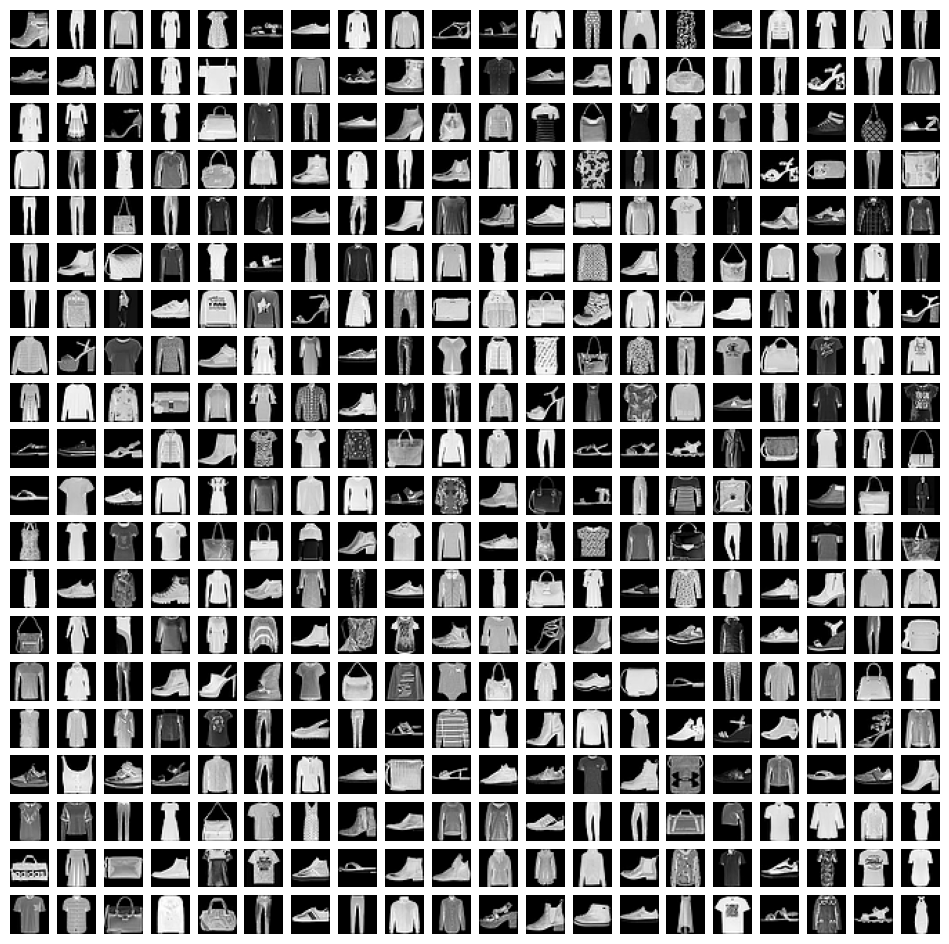

In [5]:
fig, ax = plt.subplots(20, 20, figsize=(12, 12))

for i in range(20):
    for j in range(20):
        ax[i, j].imshow(TRAIN_DATA_NP[np.random.randint(0, len(TRAIN_LABELS_NP), 1).item()].reshape(28, 28), cmap="gray")
        ax[i, j].axis("off")

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.show()

# MLP implementation

In [6]:
def init_mlp_params(layers_configuration: list[int], seed: int):
    key = jax.random.PRNGKey(seed)
    key, *subkeys = jax.random.split(key, len(layers_configuration))
    
    params = []
    for (i, units) in enumerate(layers_configuration[1:]):
        params.append((
            jax.random.normal(subkeys[i], (layers_configuration[i], layers_configuration[i + 1])), # W
            jax.random.normal(subkeys[i], (layers_configuration[i+1],))                            # b
        ))
    
    return params


@jax.jit
def forward(params, inputs):
    activations = inputs
    *hidden_layers, output_layer = params
            
    for (W, b) in hidden_layers:        
        activations = jnp.dot(activations, W) + b
        activations = jax.nn.relu(activations)
        
    return jax.nn.softmax(jnp.dot(activations, output_layer[0]) + output_layer[1])


@jax.jit
def predict(params, inputs):
    return jnp.argmax(forward(params, inputs), axis=1)


@jax.jit
def predict_proba(params, inputs):
    return forward(params, inputs)


@jax.jit
def make_safe_log(x):
    epsilon = 1e-12
    safe_x = jnp.where(x < epsilon, epsilon, x)
    
    return jnp.log(safe_x)


@jax.jit
def loss_fn(params, inputs, targets):
    targets_one_hot = jax.nn.one_hot(targets, 10)    
    preds = forward(params, inputs)
    
    result = -jnp.mean(jnp.sum(targets_one_hot * make_safe_log(preds), axis=1))
    return result


@jax.jit
def update(params, inputs, targets, lr=1e-3):
    loss_val, grads = jax.value_and_grad(loss_fn)(params, inputs, targets)
    return [(W - lr * dW, b - lr * db) for (W, b), (dW, db) in zip(params, grads)], loss_val


_params = init_mlp_params([784, 32, 10], seed=42)

batch_size = 128
iterations = 500

# get train and validation indices
np.random.seed(42)
indices = np.random.permutation(len(TRAIN_LABELS_NP))

train_indices = indices[:int(0.8 * len(TRAIN_LABELS_NP))]
val_indices = indices[int(0.8 * len(TRAIN_LABELS_NP)):]

train_batch_generator = BatchGenerator(TRAIN_DATA_NP[train_indices], TRAIN_LABELS_NP[train_indices], batch_size)
val_batch_generator = BatchGenerator(TRAIN_DATA_NP[val_indices], TRAIN_LABELS_NP[val_indices], batch_size)

history = {
    "loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_top_3_accuracy": []
}

with tqdm(total=iterations, desc='Training') as pbar:
    
    for _iter in range(iterations):            
        train_loss = 0
        for batch_X, batch_Y in train_batch_generator:
            _params, loss_val = update(_params, batch_X, batch_Y, lr=1e-3)
            train_loss += loss_val
            
        train_loss /= train_batch_generator.num_batches
        history["loss"].append(train_loss)
 
        # compute validation loss
        val_loss = 0
        for batch_X, batch_Y in val_batch_generator:
            val_loss += loss_fn(_params, batch_X, batch_Y)
            
        val_loss /= val_batch_generator.num_batches        
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(accuracy_score(TRAIN_LABELS_NP[val_indices], predict(_params, TRAIN_DATA_NP[val_indices])))
        history["val_top_3_accuracy"].append(top_k_accuracy_score(TRAIN_LABELS_NP[val_indices], predict_proba(_params, TRAIN_DATA_NP[val_indices]), k=3))
        
        pbar.set_postfix({"val_loss": val_loss, "loss": train_loss})          
        pbar.update(1)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

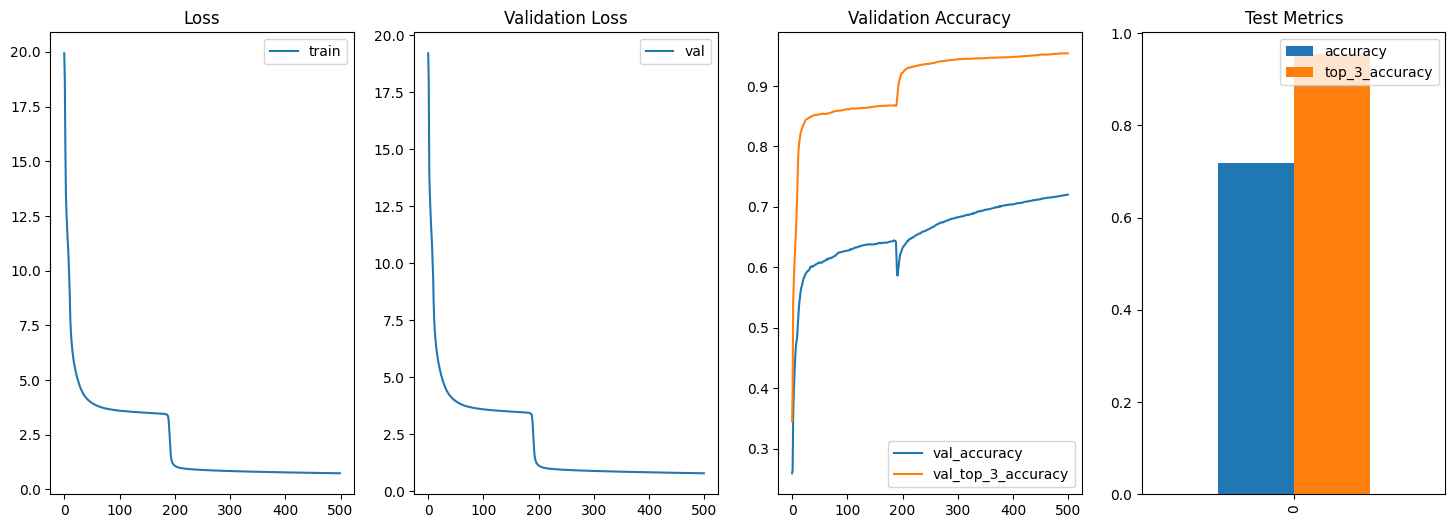

In [11]:
_, loss_ax = plt.subplots(1, 4, figsize=(18, 6))

loss_ax[0].plot(history["loss"], label="train")
loss_ax[1].plot(history["val_loss"], label="val")

loss_ax[2].plot(history["val_accuracy"], label="val_accuracy")
loss_ax[2].plot(history["val_top_3_accuracy"], label="val_top_3_accuracy")

loss_ax[0].set_title("Loss")
loss_ax[1].set_title("Validation Loss")
loss_ax[2].set_title("Validation Accuracy")

pd.DataFrame({
    "accuracy": [accuracy_score(TEST_LABELS_NP, predict(_params, TEST_DATA_NP))],
    "top_3_accuracy": [top_k_accuracy_score(TEST_LABELS_NP, predict_proba(_params, TEST_DATA_NP), k=3)]
}).plot(kind="bar", ax=loss_ax[3])

loss_ax[3].set_title("Test Metrics")

loss_ax[0].legend()
loss_ax[1].legend()
loss_ax[2].legend()
loss_ax[3].legend()

plt.show()

In [8]:
pd.DataFrame({
    "accuracy": [accuracy_score(TEST_LABELS_NP, predict(_params, TEST_DATA_NP))],
    "top_3_accuracy": [top_k_accuracy_score(TEST_LABELS_NP, predict_proba(_params, TEST_DATA_NP), k=3)]
})

,accuracy,top_3_accuracy
0,0.7187,0.954


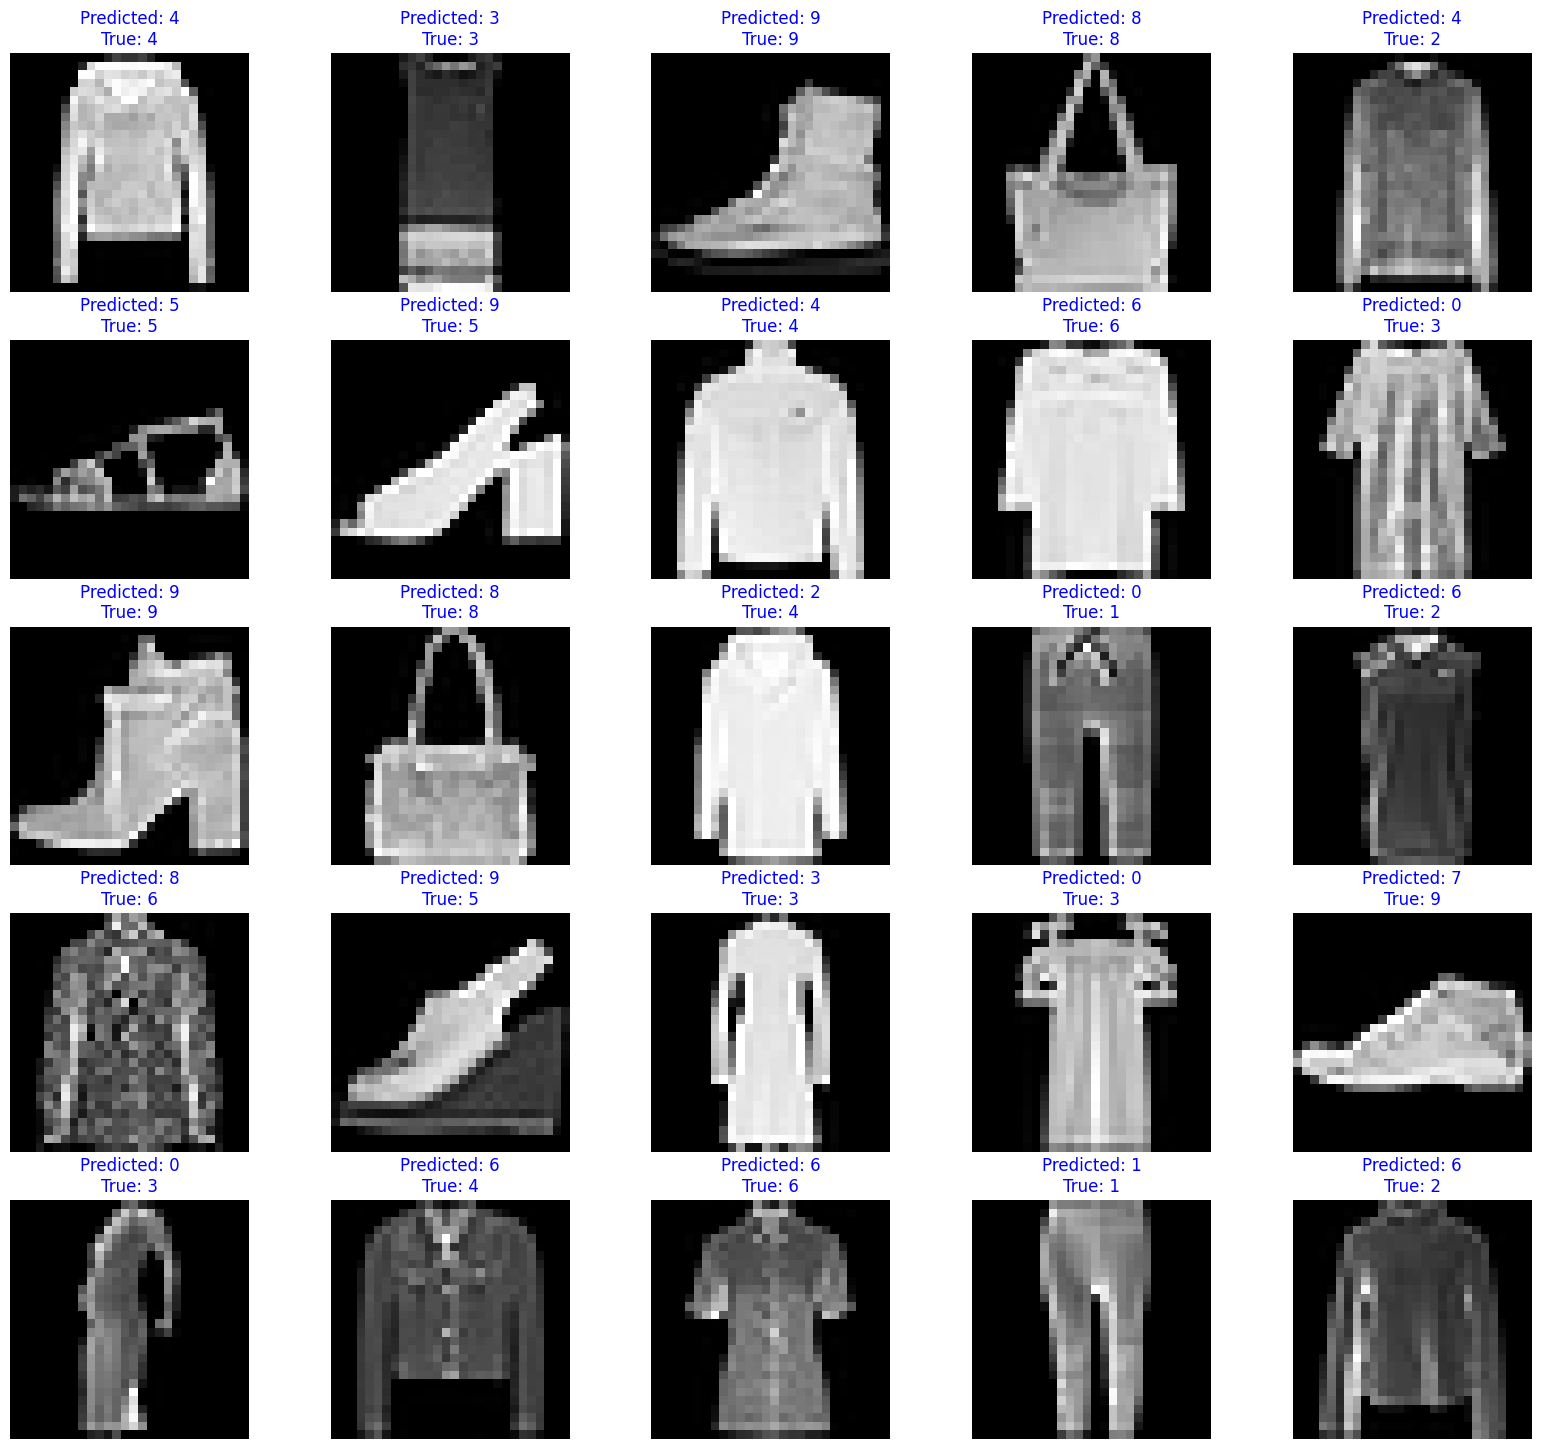

In [10]:
fig, ax = plt.subplots(5, 5, figsize=(20, 18))

for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, len(TEST_LABELS_NP), 1).item()
        ax[i, j].imshow(TEST_DATA_NP[idx].reshape(28, 28), cmap="gray")
        ax[i, j].set_title(f"Predicted: {predict(_params, TEST_DATA_NP[idx:idx+1]).item()}\nTrue: {TEST_LABELS_NP[idx]}")
        ax[i, j].axis("off")
        
        # make margin between images for better visualization
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        # text color of title make to be blue
        ax[i, j].title.set_color('blue')
                    
plt.show()